In [1]:
!pip install ucimlrepo

# **Decision Tree Classifier with Extreme Gradient Boosting (XGBoost) on Wisconsin Dataset**

### **Loading Necessary Libraries**

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

### **Loading the dataset**

In [3]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

#### **Exploratory Data Analysis**

In [4]:
print("Columns with missing or NaN values: ")

flag=True
for col in X.columns:
    if any(X[col].isna()):
        print(col)
        flag=False

if flag:
    print("There are no columns with NaN values")

Columns with missing or NaN values: 
There are no columns with NaN values


In [5]:
print("Does target value has null value? ",y.isnull().any())

Does target value has null value?  Diagnosis    False
dtype: bool


#### **H.M.V**

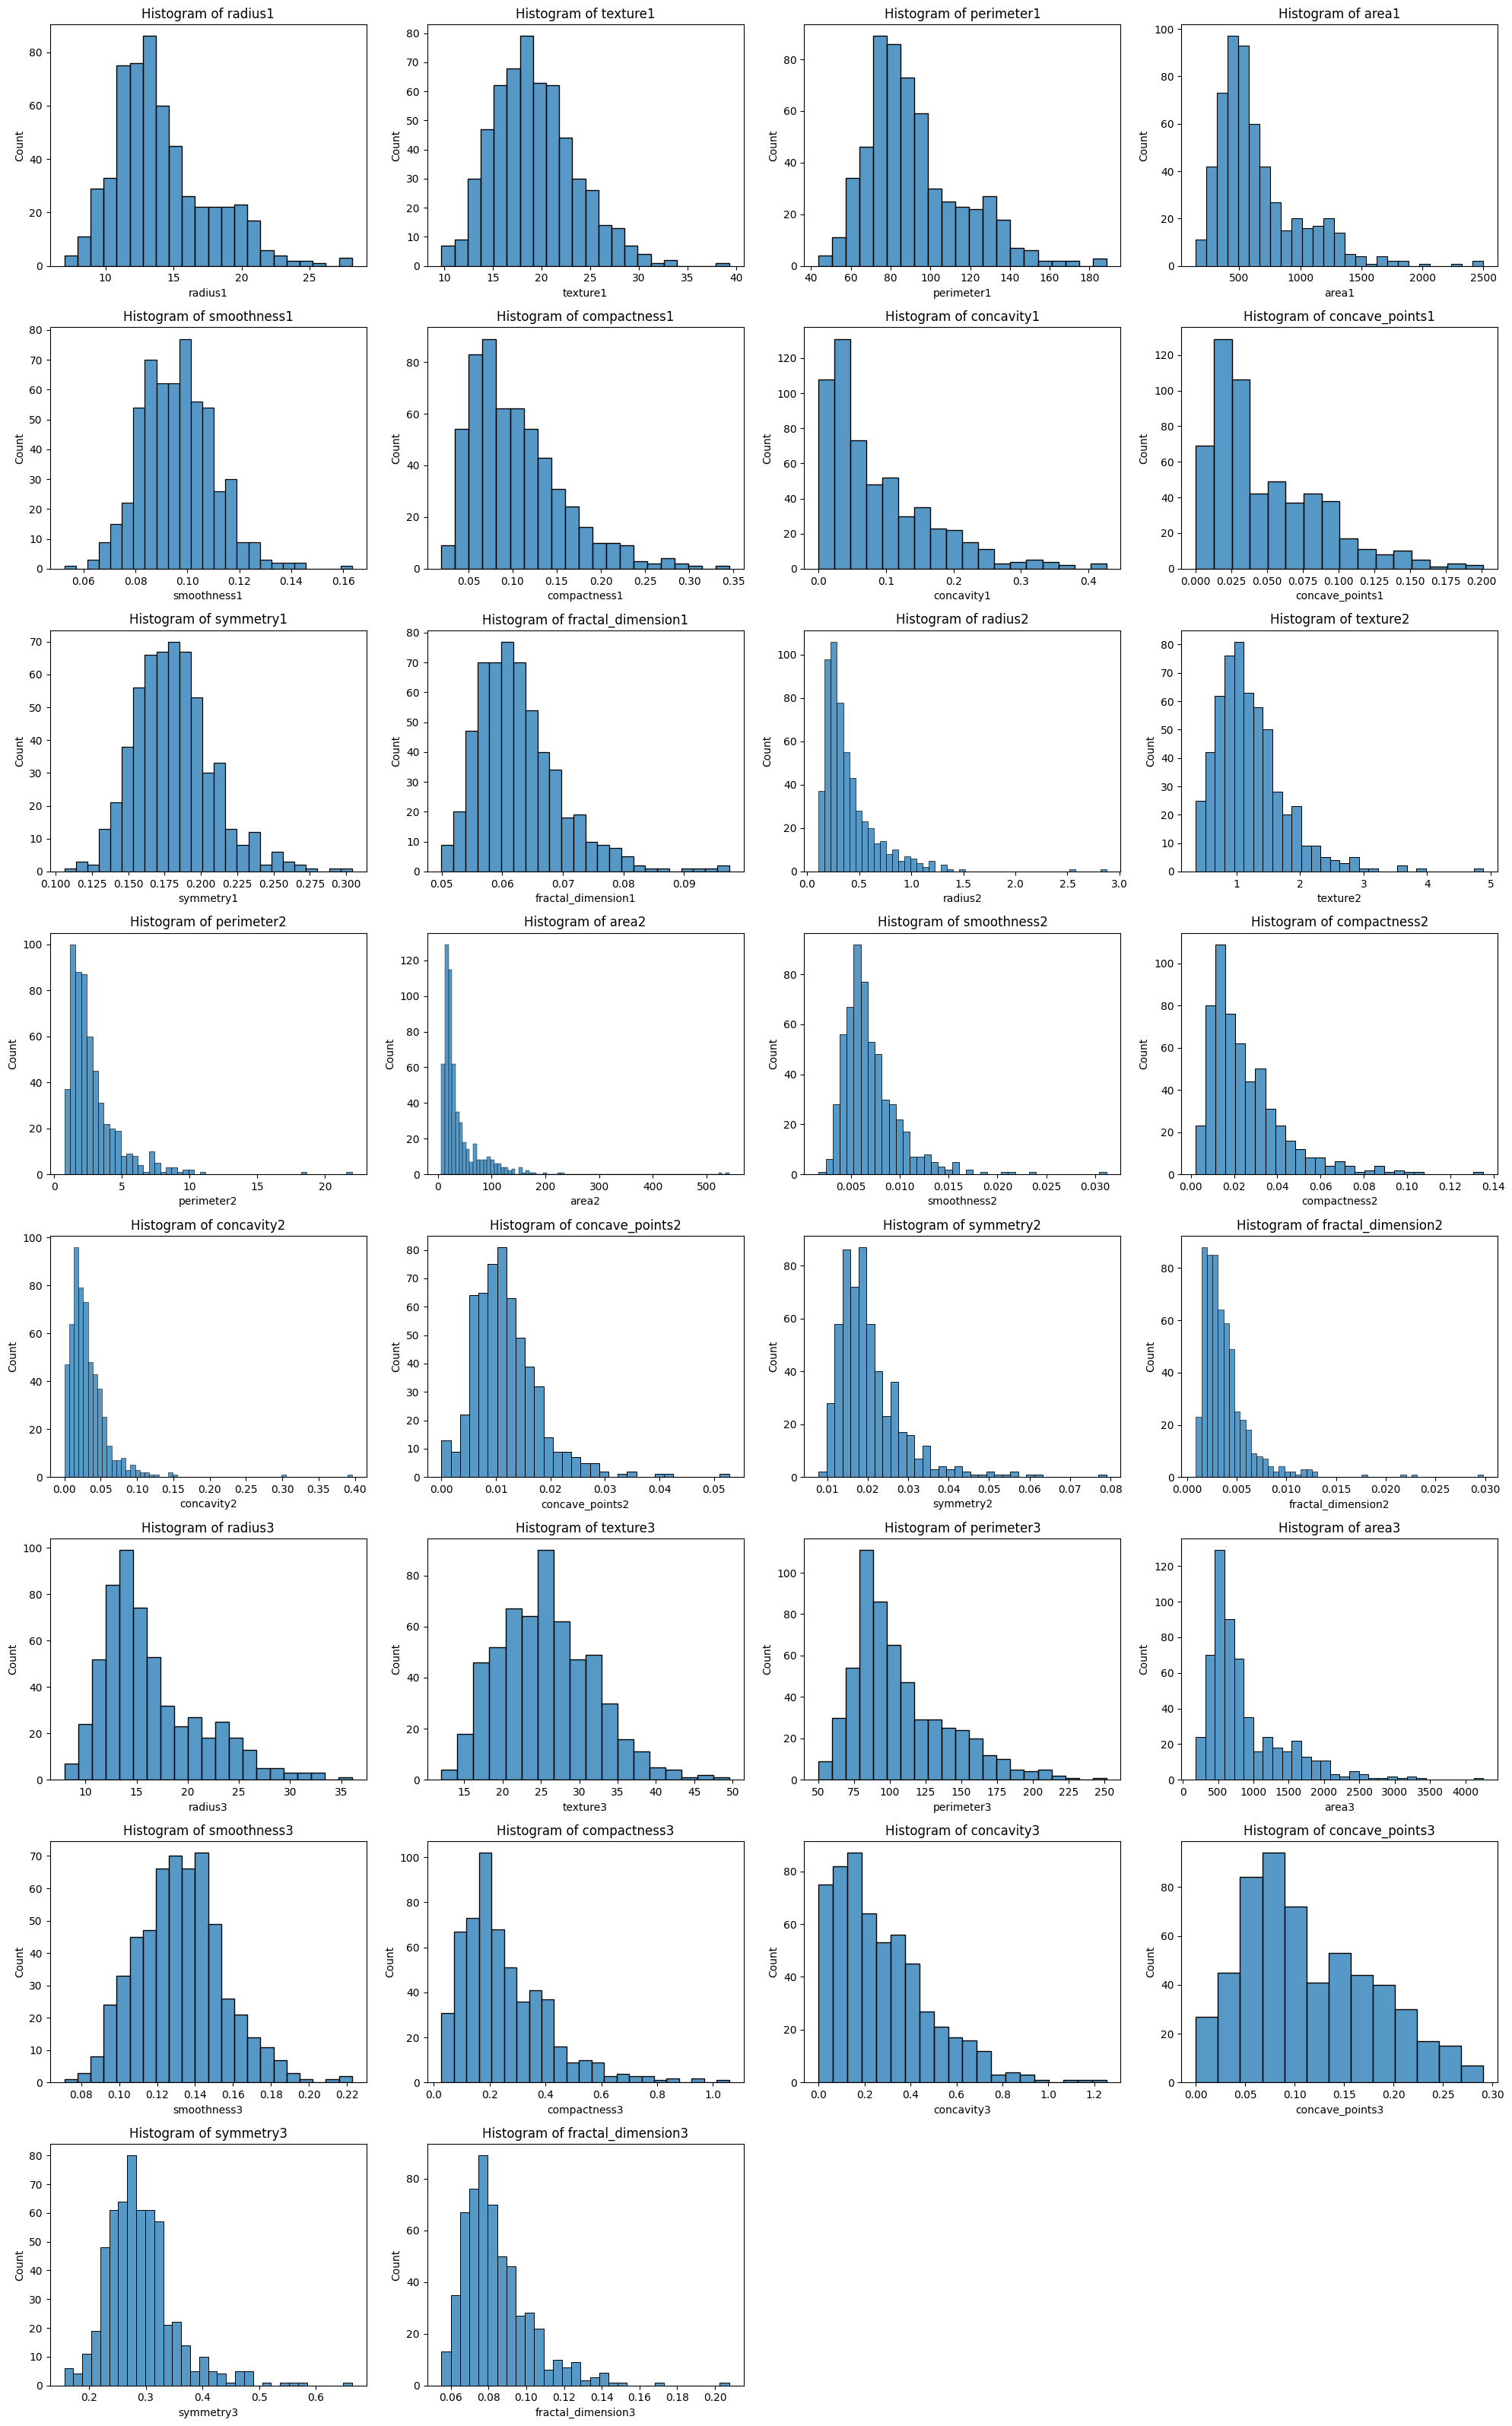

In [6]:
n = len(X.columns)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.histplot(data=X, x=column, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Hide any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Encoding**

In [7]:
np.unique(y)

array(['B', 'M'], dtype=object)

In [8]:
y=LabelEncoder().fit_transform(y)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### **Outlier Analysis**

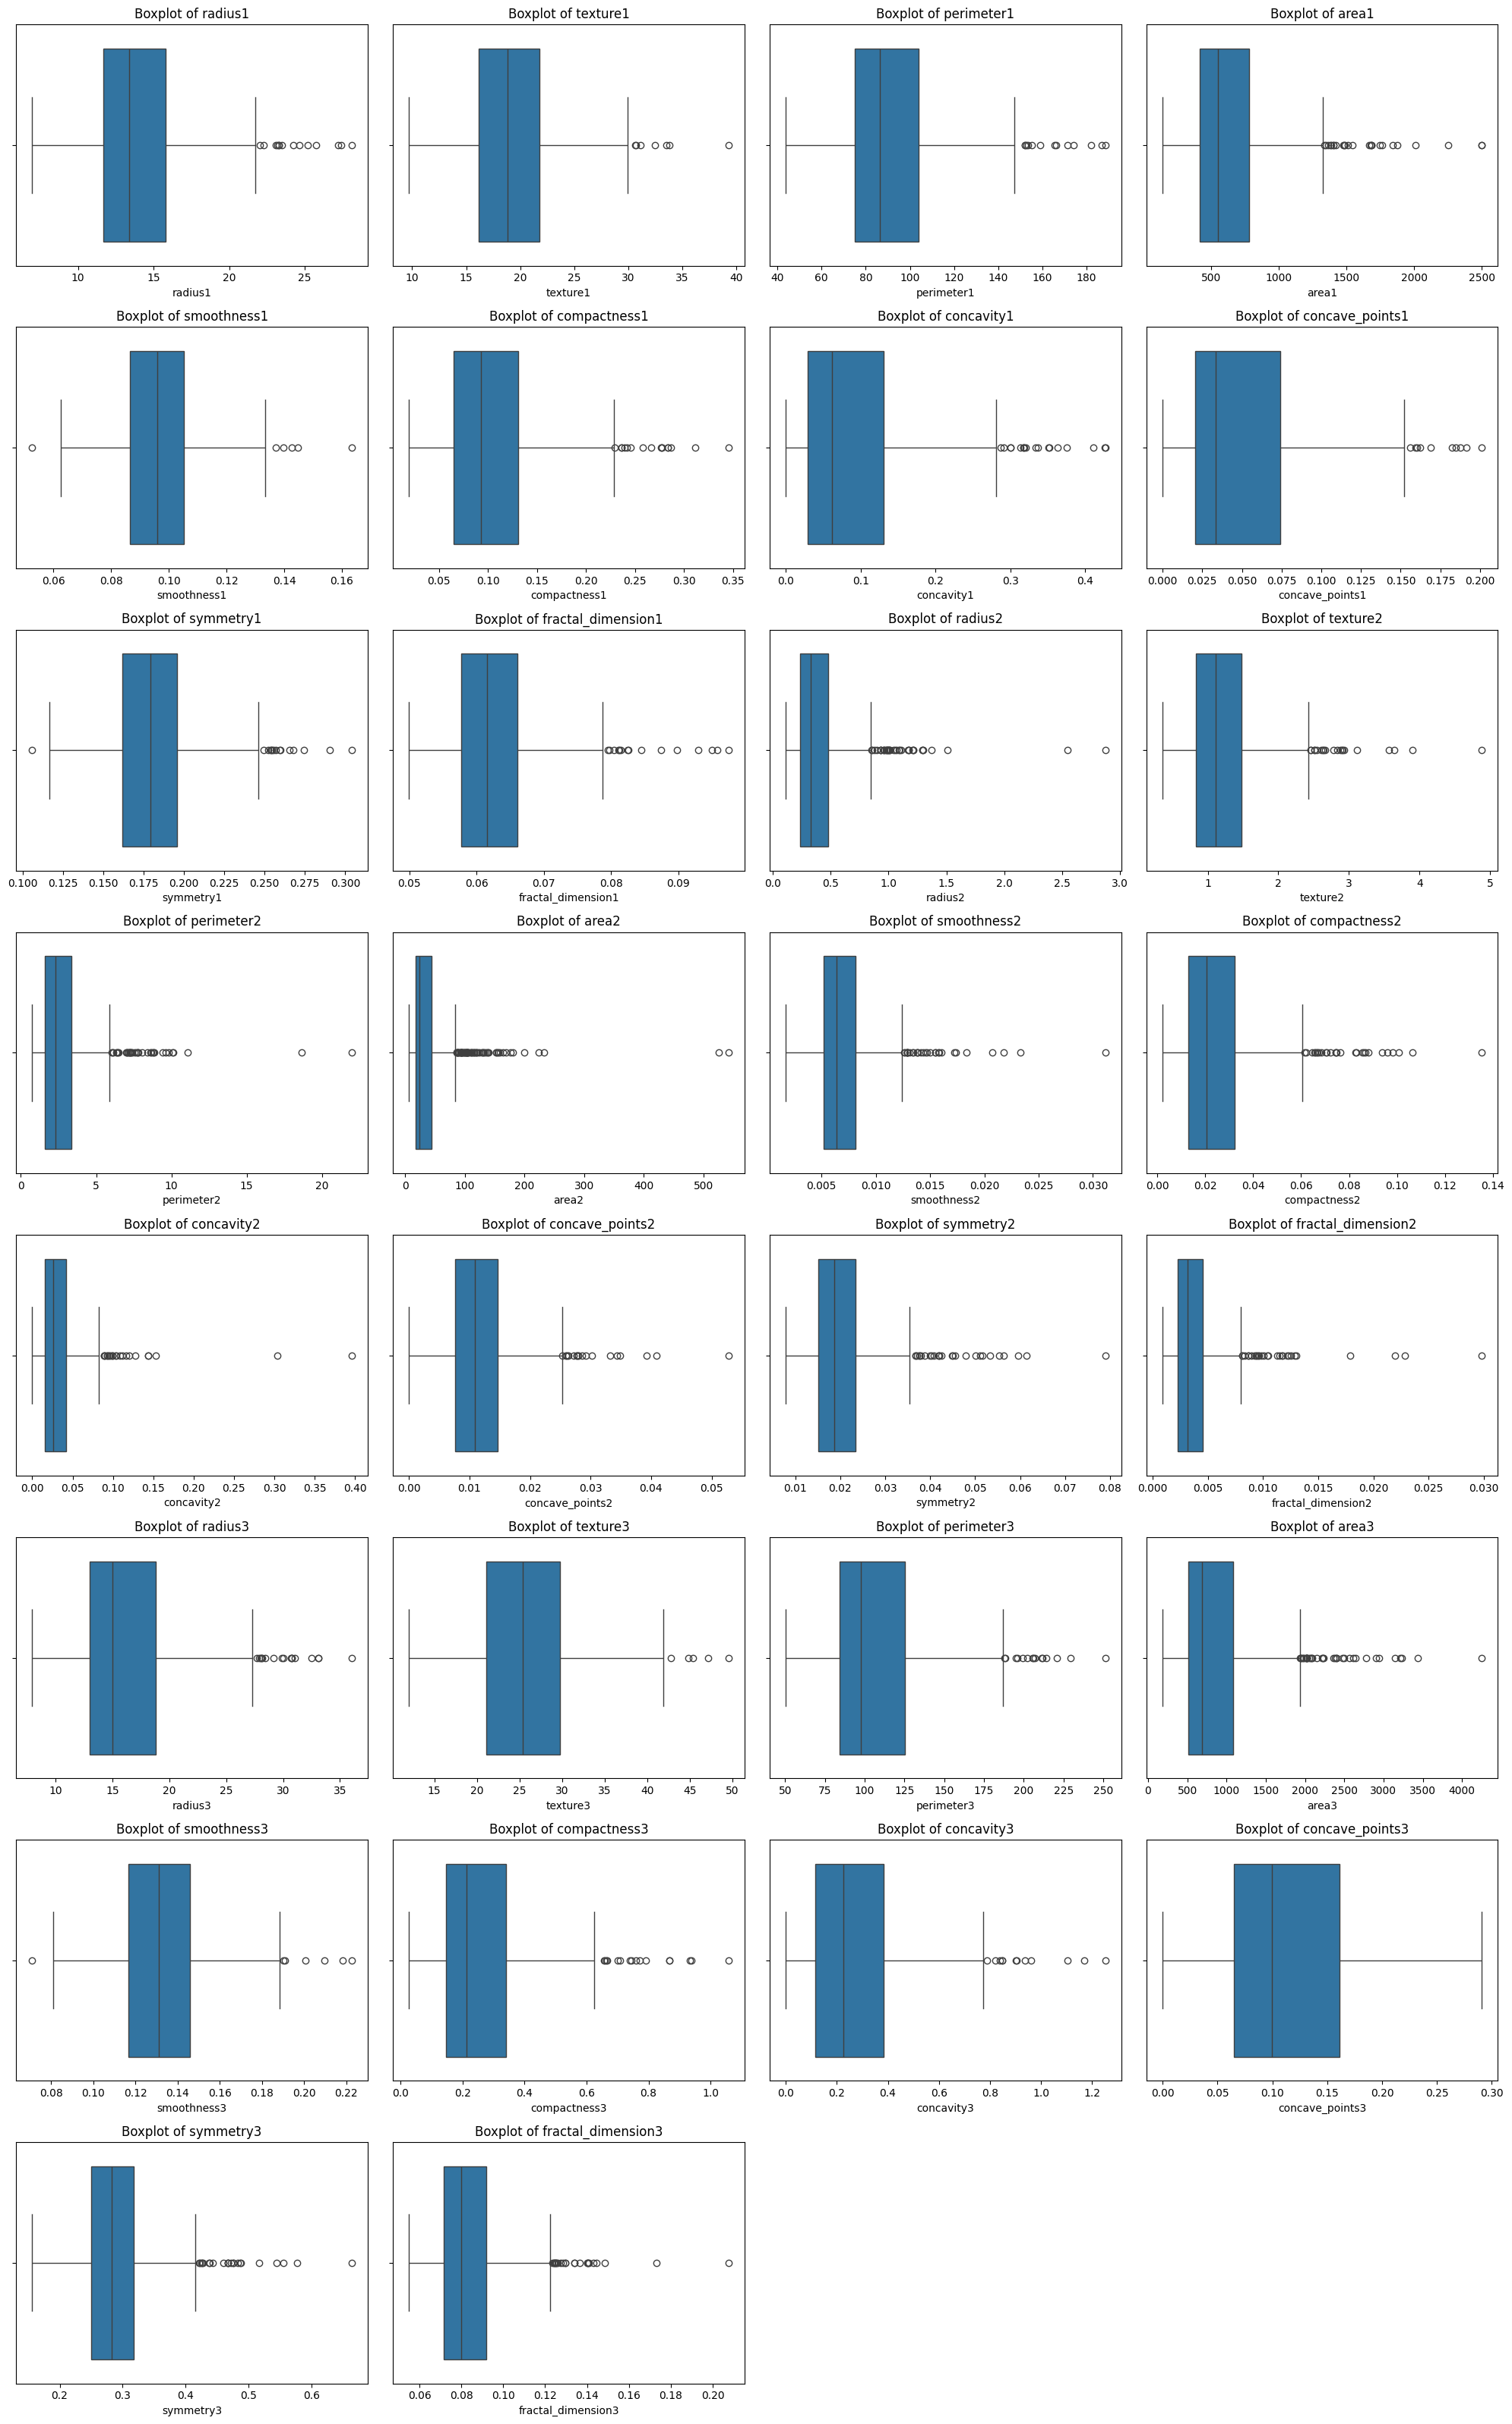

In [9]:
n = len(X.columns)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.boxplot(data=X, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

# Hide any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Standardization/Normalization**

In [10]:
#NA

### **Splitting the Dataset**

In [11]:
pca = PCA(n_components=0.95)  # keep enough PCs to explain 95% variance
X = pca.fit_transform(X)

print("Number of PCs chosen:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Number of PCs chosen: 1
Explained variance ratio: [0.98204467]


In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

### **Model**

In [13]:


# Base model
base_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],       # Number of boosting rounds (trees)
    'max_depth': [3, 5, 7],           # Depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],# Step size shrinkage
    'subsample': [0.8, 1.0],          # Fraction of samples for training each tree
    'colsample_bytree': [0.8, 1.0],   # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2, 0.5, 1] ,
}

# Grid search
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

# Fit
grid.fit(X_train, y_train)

# Results
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.8943354430379747


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
best_model = grid.best_estimator_

scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy in each fold:", scores)
print("Mean CV Accuracy:", scores.mean())

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:31] WARNING: /w

Accuracy in each fold: [0.9        0.925      0.9125     0.86075949 0.87341772]
Mean CV Accuracy: 0.8943354430379747


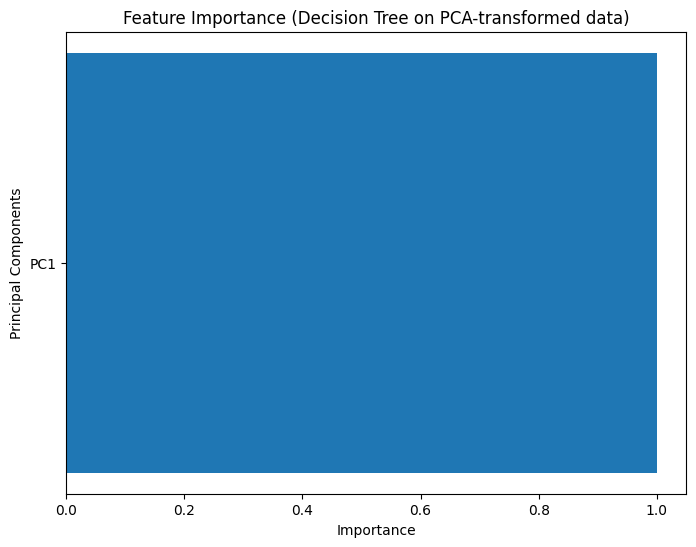

In [15]:
# Extract feature importances
importances = best_model.feature_importances_

# Label components as PC1, PC2, ...
features = [f"PC{i+1}" for i in range(X_train.shape[1])]

# Create DataFrame
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()  # highest importance at top
plt.title("Feature Importance (Decision Tree on PCA-transformed data)")
plt.xlabel("Importance")
plt.ylabel("Principal Components")
plt.show()


### **Performance Analysis**

**Training Set**

In [16]:
y_pred_train = best_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
class_report = classification_report(y_train, y_pred_train)

print("Train Performance (Best Model)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", class_report)

Train Performance (Best Model)
Accuracy: 0.9095477386934674
Precision: 0.9312977099236641
Recall: 0.8187919463087249
F1 Score: 0.8714285714285714

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       249
           1       0.93      0.82      0.87       149

    accuracy                           0.91       398
   macro avg       0.92      0.89      0.90       398
weighted avg       0.91      0.91      0.91       398



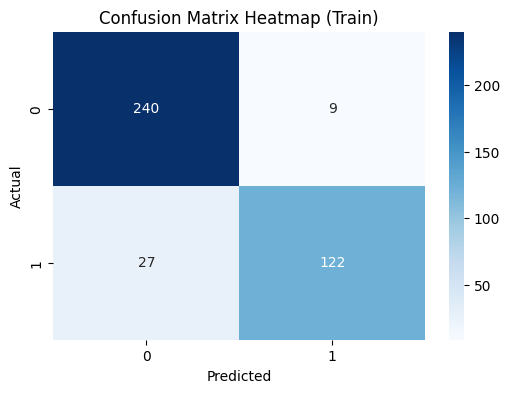

In [17]:
cm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Train)')
plt.show()

ROC AUC Score (Train): 0.9692461119646372


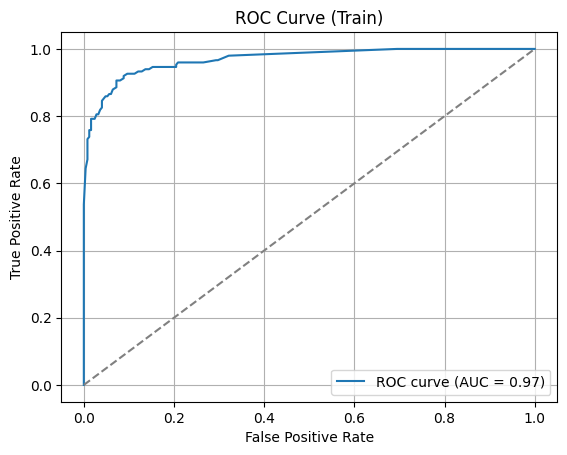

In [18]:
y_proba_train = best_model.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_proba_train)
fpr, tpr, thresholds = roc_curve(y_train, y_proba_train)

print("ROC AUC Score (Train):", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend()
plt.grid(True)
plt.show()

**Testing Set**

In [19]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Test Performance (Best Model)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", class_report)

Test Performance (Best Model)
Accuracy: 0.9532163742690059
Precision: 0.9365079365079365
Recall: 0.9365079365079365
F1 Score: 0.9365079365079365

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



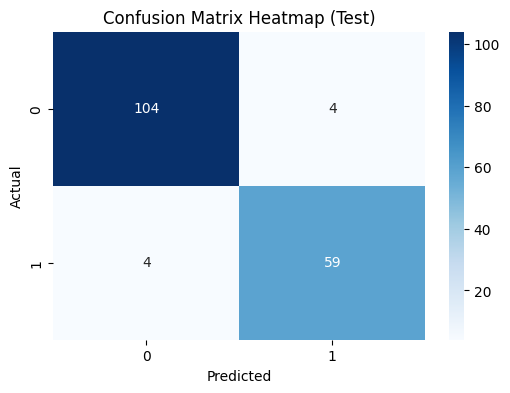

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap (Test)')
plt.show()

ROC AUC Score (Test): 0.9876543209876544


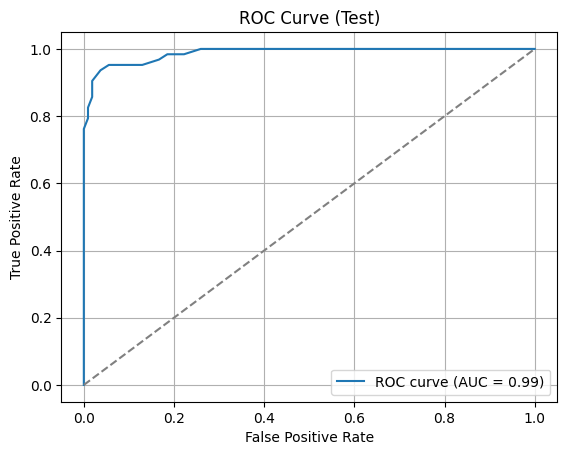

In [21]:
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

print("ROC AUC Score (Test):", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend()
plt.grid(True)
plt.show()


**Report for Best Model**

In [22]:
print("\nOther Models (Classification Report on Test Data):\n")

for mean_score, params, rank in zip(
        grid.cv_results_['mean_test_score'],
        grid.cv_results_['params'],
        grid.cv_results_['rank_test_score']):

    if params != grid.best_params_:  # exclude best model
        temp_model = XGBClassifier(**params,
                                   use_label_encoder=False,
                                   eval_metric='mlogloss',
                                   random_state=42)
        temp_model.fit(X_train, y_train)
        y_pred_other = temp_model.predict(X_test)
        print(f"Params: {params} | CV Score: {mean_score:.4f} | Rank: {rank}")
        print(classification_report(y_test, y_pred_other))
        print("="*60)


Other Models (Classification Report on Test Data):

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 113
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 43
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 109


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       108
           1       0.95      0.89      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       108
           1       0.95      0.89      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 253
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 279
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 323
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8767 | Rank: 287
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 323
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 279
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 341
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8692 | Rank: 343
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8618 | Rank: 355
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8668 | Rank: 345
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8643 | Rank: 349
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, '

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 253
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       108
           1       0.89      0.92      0.91        63

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8718 | Rank: 309
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       108
           1       0.90      0.89      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 279
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8767 | Rank: 289
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 269
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8617 | Rank: 359
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       0.92      0.94      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /w

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       108
           1       0.89      0.92      0.91        63

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 205
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8718 | Rank: 309
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:39] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8717 | Rank: 317
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /w

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8868 | Rank: 121
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8918 | Rank: 17
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8943 | Rank: 1
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, '

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /w

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       108
           1       0.90      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 243
              precision    recall  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 245
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 0.8, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /w

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       108
           1       0.88      0.94      0.91        63

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8743 | Rank: 293
              precision    recall  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'ga

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /w

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8793 | Rank: 245
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 39
              precision    recall  f1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8793 | Rank: 245
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 121
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 201
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 43
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamm

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /w

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-sc

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /w

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 0.8, 'gamma

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'ga

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamm

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       108
           1       0.95      0.89      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 253
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 279
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 323
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 279
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 341
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8692 | Rank: 343
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8718 | Rank: 305
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8742 | Rank: 303
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8618 | Rank: 355
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8667 | Rank: 347
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       108
           1       0.86      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8743 | Rank: 291
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       108
           1       0.85      0.92      0.89        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8668 | Rank: 345
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 113
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recal

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /w

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 43
              precision    recall

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 109
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 253
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       108
           1       0.89      0.92      0.91        63

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /w

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       108
           1       0.88      0.90      0.89        63

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.91       171
weighted avg       0.92      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8718 | Rank: 309
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 269
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       108
           1       0.95      0.89      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       108
           1       0.86      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8768 | Rank: 269
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 43
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       0.92      0.94      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       108
           1       0.91      0.94      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8718 | Rank: 309
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       108
           1       0.88      0.92      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8642 | Rank: 351
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /w

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8693 | Rank: 327
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8868 | Rank: 121
              precision    recall

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8894 | Rank: 23
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 205
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       108
           1       0.90      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8793 | Rank: 253
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8743 | Rank: 293
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       108
           1       0.89      0.92      0.91        63

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, '

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8869 | Rank: 73
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       108
           1       0.98      0.87      0.92        63

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'ga

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 39
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'ga

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 39
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8793 | Rank: 245
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 121
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8818 | Rank: 201
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gam

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8843 | Rank: 137
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8893 | Rank: 43
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamm

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | CV Score: 0.8893 | Rank: 55
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8868 | Rank: 121
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       108
           1       0.94      0.94      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamm

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /w

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-sc

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:22:56] WARNING: /w

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} | CV Score: 0.8843 | Rank: 169
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0} | CV Score: 0.8919 | Rank: 5
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

